In [128]:
from socrata_api import socrata_api_wrapper as saw
from psql_helper import psql_helper as ph 
from footballdb_scraper import footballdb_scraper as fs
from baseball_almanac_scraper import baseball_almanac_scraper as bas
from wunderground_scraper import wunderground_scraper as ws
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
import psycopg2
import seaborn as sns
%matplotlib inline

In [2]:
wunder = ws.WundergroundScraper()
wunder.download_date_range('2009-06-17', '2015-09-14')

data/weather.csv downloaded.


In [8]:
token = 'Opp5gz1KaGplrPjbqnSsWkqHB'

In [9]:
api = saw.SocrataAPI(token)
psql = ph.PsqlConnection(db='traffic_accident', user='minghuang')

Connection Open


### Get 911 response data (original data source intended, traffic accident data seemed insufficient)

In [4]:
r = api.request('https://data.seattle.gov/resource/pu5n-trf4.json')
headers = r.get_headers()
r.set_primary_id('cad_cdw_id')

In [5]:
r.download_csv(file_name='data/raw_911_response.csv')

Download Complete


In [6]:
#psql.drop_table('raw_911_response')
#psql.create_table(headers, 'raw_911_response')
#psql.insert_csv('raw_911_response', '/Users/minghuang/Documents/temp/911calls.csv')

Table raw_911_response dropped.
Table raw_911_response created in traffic_accident
CSV inserted into raw_911_response.


###Get road weather data

In [9]:
r = api.request('https://data.seattle.gov/resource/egc4-d24i.json')
headers = r.get_headers()
r.set_primary_id('recordid')

Connection Open


In [12]:
r.download_csv(file_name='data/raw_road_weather.csv')

Download Complete


In [8]:
#psql.drop_table('raw_road_weather')
#psql.create_table(headers, 'raw_road_weather')
#psql.insert_csv('raw_road_weather', '/Users/minghuang/Documents/temp/roadweather.csv')

Table raw_road_weather dropped.
Table raw_road_weather created in traffic_accident
CSV inserted into raw_road_weather.


###Get Mariner and Seahawks schedule

In [13]:
mariner = bas.BaseballAlmanacScraper()
mariner.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [14]:
seahawks = fs.FootballdbScraper()
seahawks.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [12]:
psql.load_csvs_in_directory('/Users/minghuang/Documents/git/SEA_traffic_accident_prediction/data')

Table raw_traffic_accident dropped.
Table raw_traffic_accident created in traffic_accident
CSV inserted into raw_traffic_accident.


In [13]:
psql.end_connection()

Connection Closed


#EDA

In [63]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
query = "select * from raw_911_response where event_clearance_code like '4%';"
df = pd.read_sql_query(query, con=conn)
conn.close()

In [65]:
df.head()

,cad_cdw_id,at_scene_time,cad_event_number,census_tract,district_sector,event_clearance_code,event_clearance_date,event_clearance_description,event_clearance_group,event_clearance_subgroup,general_offense_number,hundred_block_location,incident_location,initial_type_description,initial_type_group,initial_type_subgroup,latitude,longitude,zone_beat
0,933098,2012-10-08T14:05:00.000,12000344481,2700.6003,J,430,2012-10-08T14:26:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344481,82XX BLOCK OF WALLINGFORD AVE N,"{u'type': u'Point', u'coordinates': [-122.3364...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.689605057,-122.336431336,J1
1,933094,2012-10-08T10:42:00.000,12000344272,9000.3010,E,430,2012-10-08T11:09:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344272,S JACKSON ST / RAINIER AV S,"{u'type': u'Point', u'coordinates': [-122.3141...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.599208685,-122.314137588,E3
2,933093,2012-10-08T10:34:00.000,12000344248,8500.1016,D,430,2012-10-08T10:41:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344248,9 AV / COLUMBIA ST,"{u'type': u'Point', u'coordinates': [-122.3260...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.606980062,-122.326056105,D3
3,933091,2012-10-09T10:26:00.000,12000345578,4100.7004,L,430,2012-10-09T10:46:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012345578,NE 42 ST / 53 AV NE,"{u'type': u'Point', u'coordinates': [-122.2710...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.658716136,-122.271070825,L3
4,933089,2012-10-09T13:12:00.000,12000345782,4100.7004,L,430,2012-10-09T13:48:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012345782,NE 42 ST / 53 AV NE,"{u'type': u'Point', u'coordinates': [-122.2710...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.658716136,-122.271070825,L3
5,933085,2012-10-08T07:13:00.000,12000344077,2700.5000,J,430,2012-10-08T08:13:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012344077,N 80 ST / DENSMORE AV N,"{u'type': u'Point', u'coordinates': [-122.3379...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.686918091,-122.33790776,J1
6,933084,2012-10-05T10:48:00.000,12000340255,8900.1008,G,430,2012-10-05T11:17:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012340255,5XX BLOCK OF LAKESIDE AVE S,"{u'type': u'Point', u'coordinates': [-122.2873...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.597259551,-122.287335203,G3
7,933080,2012-10-04T09:33:00.000,12000338807,2600.4006,U,430,2012-10-04T09:58:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012338807,NE 75 ST / 15 AV NE,"{u'type': u'Point', u'coordinates': [-122.3120...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.68304447,-122.312080524,U1
8,933078,2012-10-05T12:02:00.000,12000340391,6800.2003,Q,430,2012-10-05T12:42:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012340391,18XX BLOCK OF 1ST AVE N,"{u'type': u'Point', u'coordinates': [-122.3556...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.635261807,-122.35562275,Q2
9,933077,2012-10-03T11:14:00.000,12000337543,9300.3096,O,430,2012-10-03T11:43:00.000,ACCIDENT INVESTIGATION,ACCIDENT INVESTIGATION,TRAFFIC RELATED CALLS,2012337543,47XX BLOCK OF E MARGINAL WAY S,"{u'type': u'Point', u'coordinates': [-122.3394...",TRU - ACC - HIT AND RUN,TRAFFIC RELATED CALLS,ACCIDENT INVESTIGATION,47.559935547,-122.339440551,O2


In [44]:
len(df.zone_beat.unique())

55

In [23]:
#df.initial_type_description.unique()

In [4]:
lgt = df.longitude.astype(float).values
lat = df.latitude.astype(float).values

In [5]:
print min(lgt), max(lgt)
print min(lat), max(lat)

-122.419091527 -122.237546385
47.496401905 47.734128229


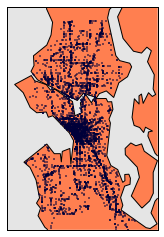

In [6]:
m = Basemap(projection='merc',# lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.45, llcrnrlat=47.5,
    urcrnrlon=-122.2, urcrnrlat=47.75)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

x, y = m(lgt, lat)
m.plot(x, y, 'bo', markersize=1)
 
plt.show()

#### Lets look at my sql transformed data (additional EDA were done in SQL, but not recorded)

In [2]:
query = 'select * from compiled_data;'

In [3]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
df2 = pd.read_sql_query(query, con=conn)
conn.close()

In [4]:
df2 = df2.reindex(np.random.permutation(df2.index))

In [5]:
df2 = df2.sample(10000)

In [6]:
df2.head()

,zone_beat_id,condition_id,winddir_id,hour,dow,month,mariner_plays,seahawk_plays,dewpoint,gustspeed,heatindex,humidity,precip,pressure,temp,visibility,windspeed,label
508988,9,18,13,9,4,8,0,0,55.0,0,0,90,0.00,30.03,57.9,5.0,4.6,0
1097887,11,18,6,8,5,12,0,0,30.9,0,0,92,0.00,30.33,33.1,7.0,3.5,0
2311814,36,2,1,20,0,9,0,0,50.0,0,0,44,0.00,29.80,73.4,10.0,0.0,0
2427391,47,12,14,13,4,12,0,0,48.0,0,0,89,0.11,29.19,51.1,6.0,5.8,0
2030232,25,18,1,0,0,1,0,1,37.4,0,0,93,0.00,30.18,39.2,0.8,0.0,0


In [7]:
df3 = df2[['dewpoint', 'gustspeed', 'heatindex', 'humidity', 'precip', 'pressure', 'temp', 'visibility', 'windspeed', 'label']]

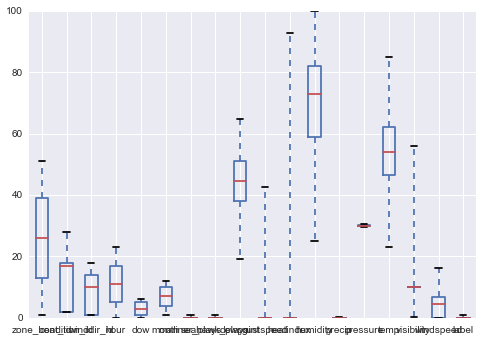

In [13]:
plot = df2.boxplot()

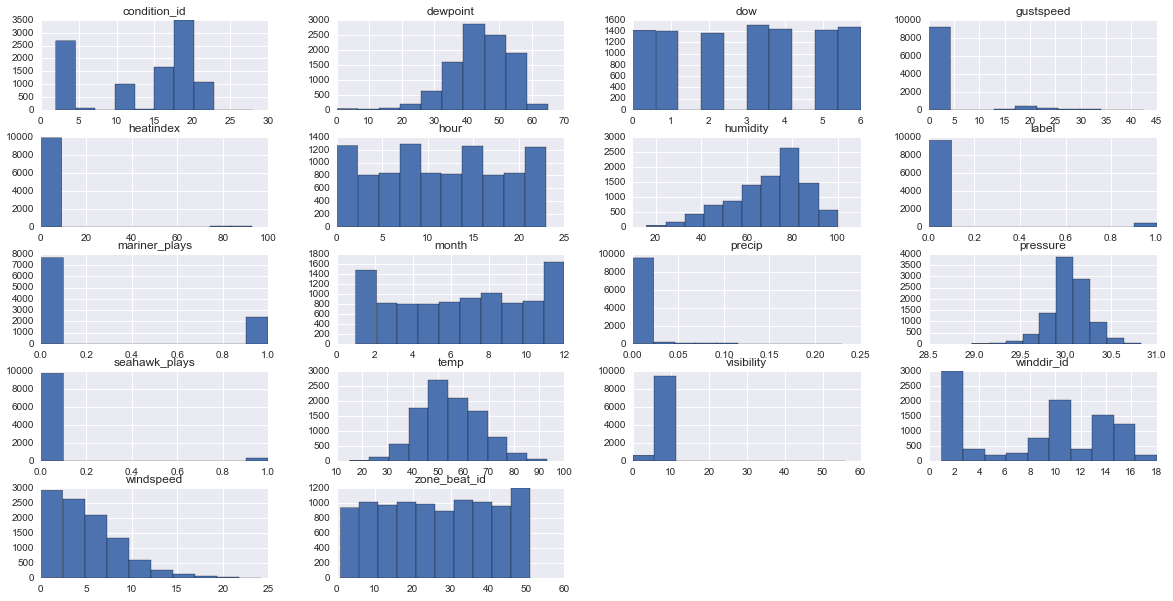

In [15]:
plot = df2.hist(figsize=(20, 10))

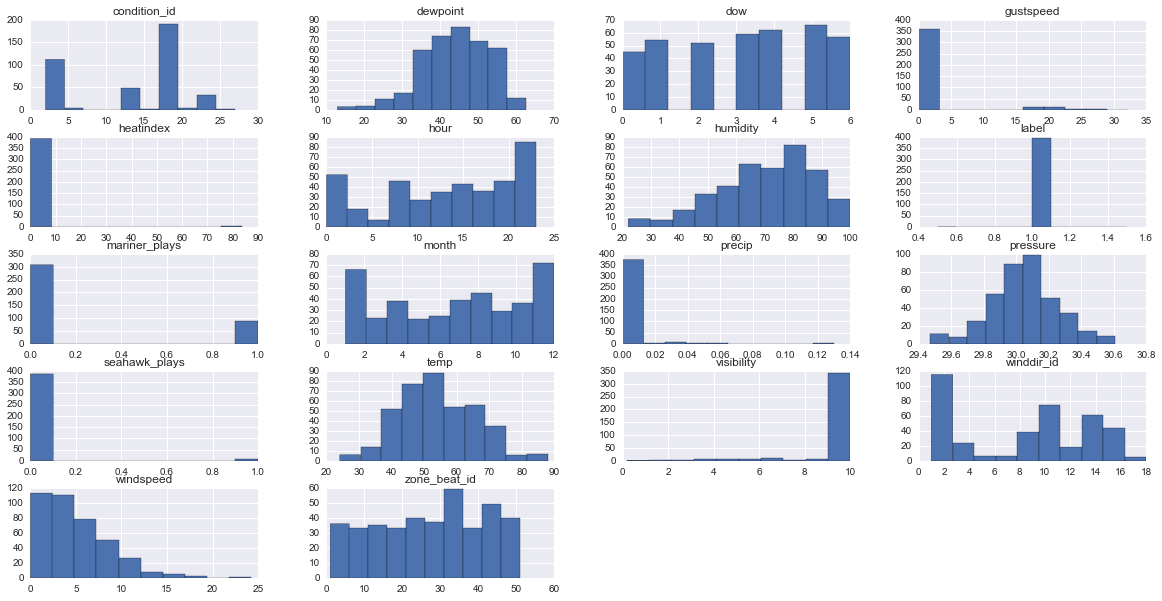

In [16]:
plot = df2[df2.label == 1].hist(figsize=(20, 10))

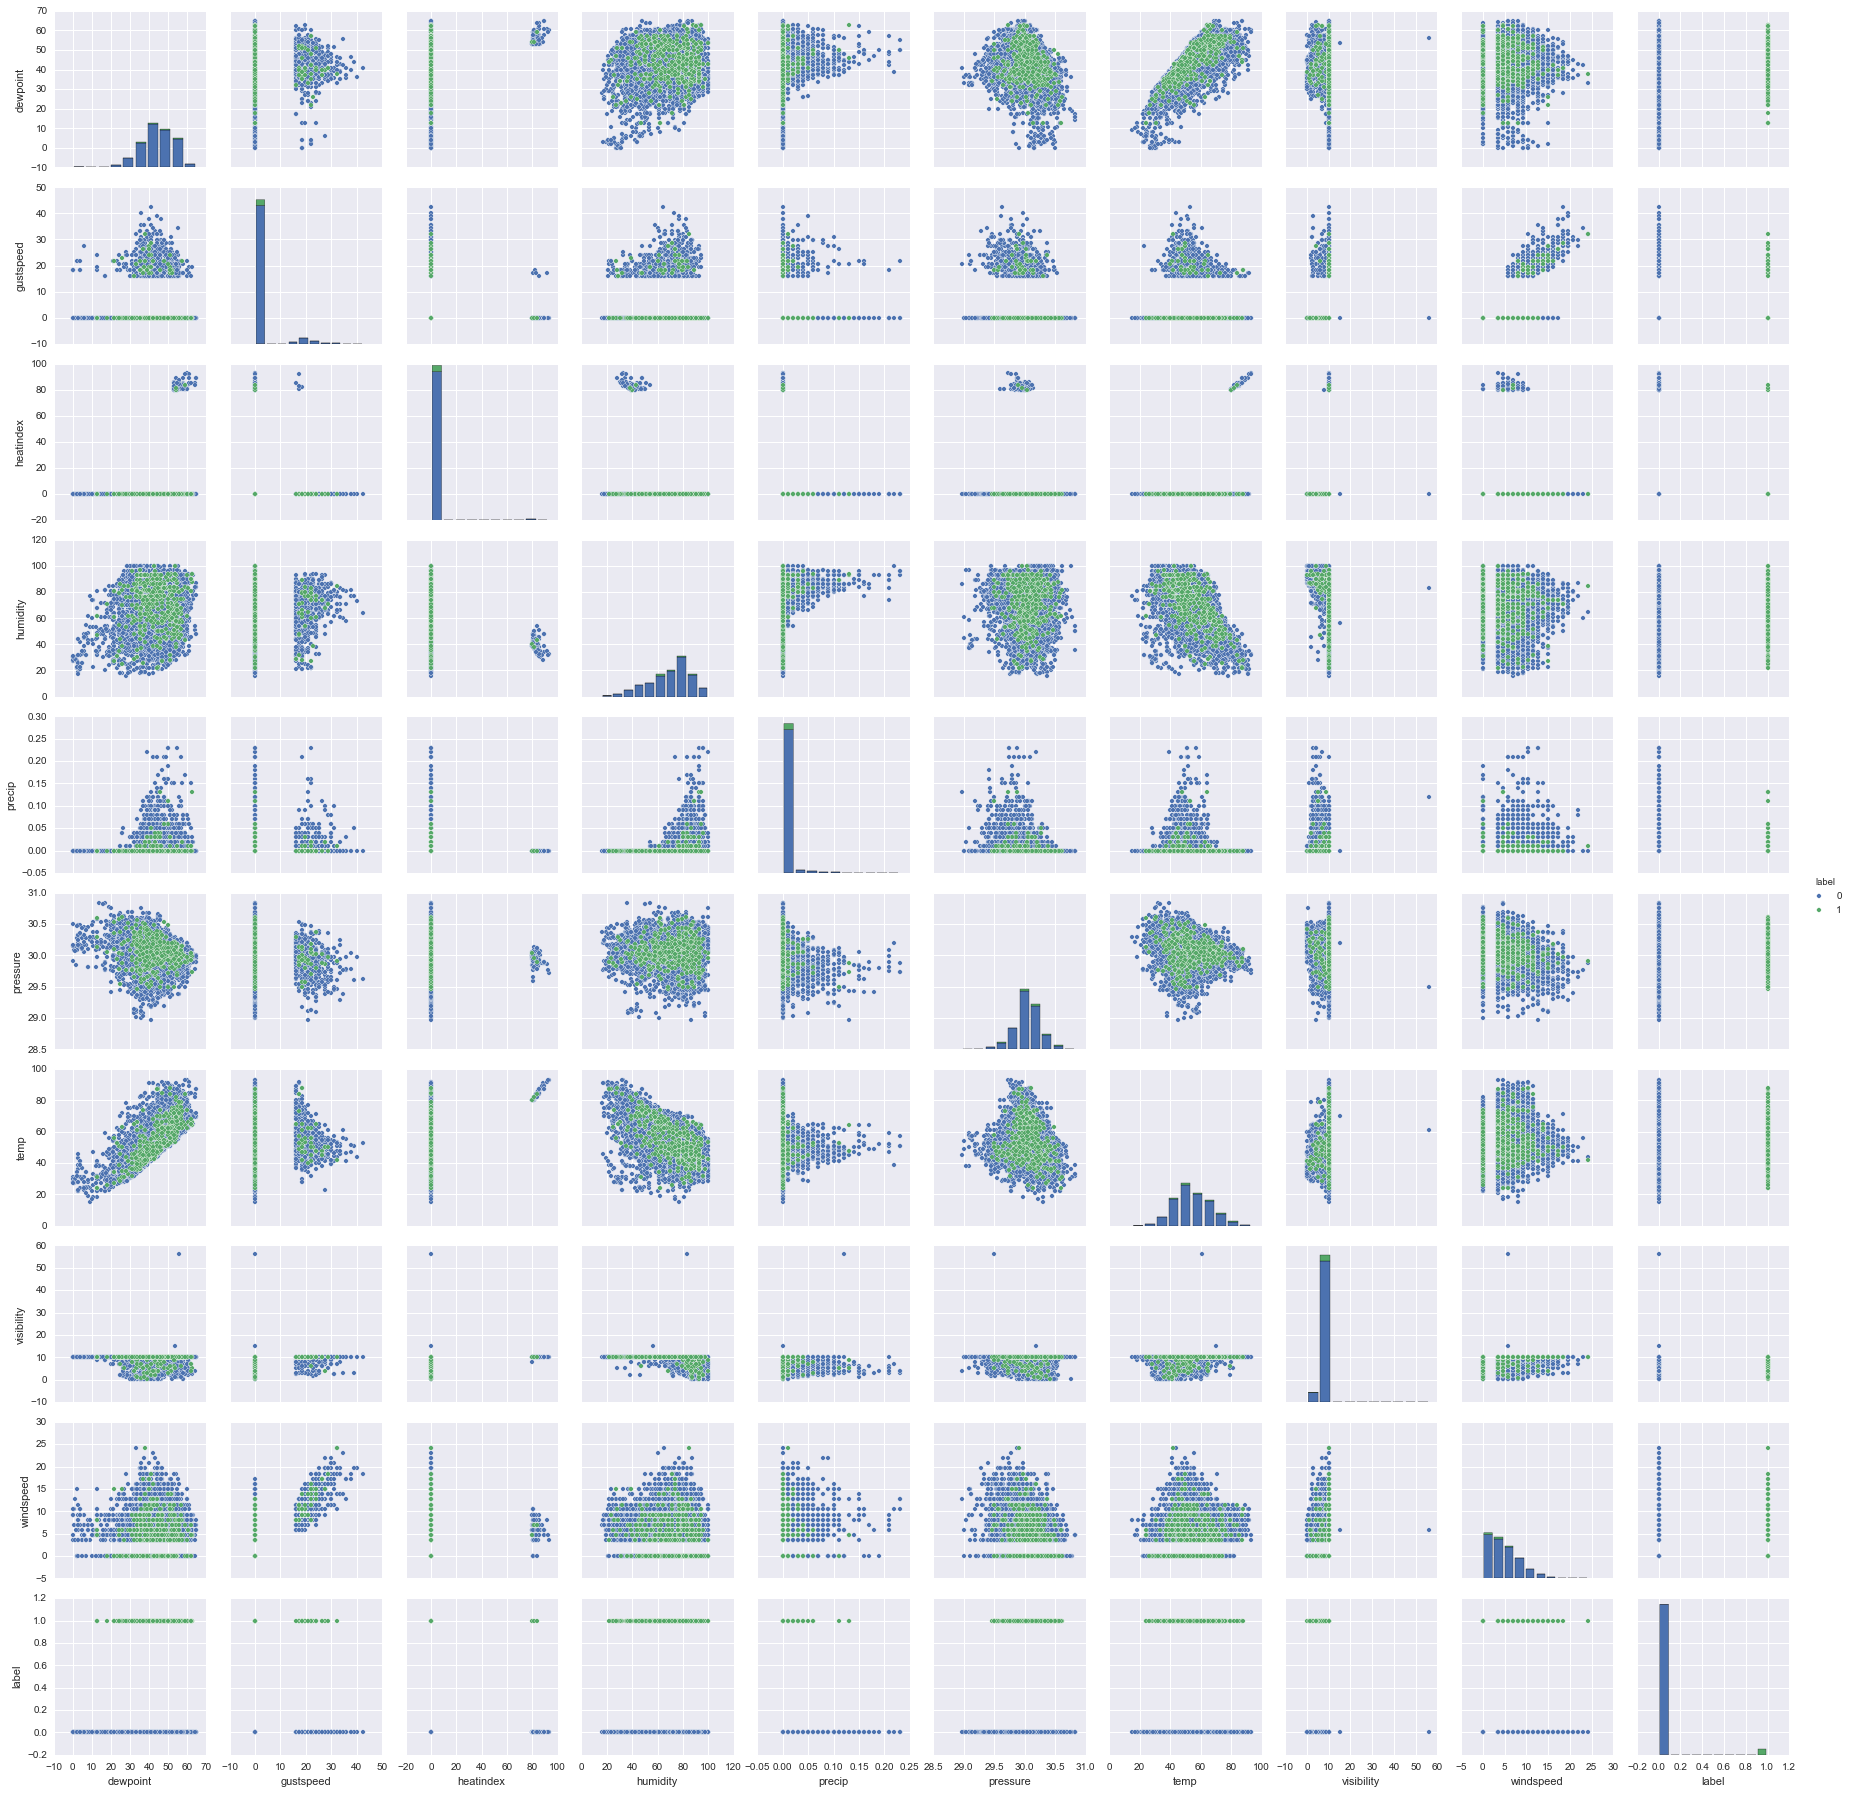

In [10]:
sns.set()
sns.pairplot(df3, hue='label')

In [17]:
print '0 label count:', df2[df2.label == 0]['label'].count()
print '1 label count:', df2[df2.label == 1]['label'].count()

0 label count: 9605
1 label count: 395


In [18]:
y = df2.pop('label').values
df2.sort(axis=1).head().T

,508988,1097887,2311814,2427391,2030232
condition_id,18.00,18.00,2.0,12.00,18.00
dewpoint,55.00,30.90,50.0,48.00,37.40
dow,4.00,5.00,0.0,4.00,0.00
gustspeed,0.00,0.00,0.0,0.00,0.00
heatindex,0.00,0.00,0.0,0.00,0.00
hour,9.00,8.00,20.0,13.00,0.00
humidity,90.00,92.00,44.0,89.00,93.00
mariner_plays,0.00,0.00,0.0,0.00,0.00
month,8.00,12.00,9.0,12.00,1.00
precip,0.00,0.00,0.0,0.11,0.00


In [19]:
X = df2.sort(axis=1).values

#### Doesn't look great... lets just try some models

In [20]:
encoder = OneHotEncoder(categorical_features=[0, 2, 5, 8, 14, 16])
mat = encoder.fit_transform(X)

In [21]:
logit = LogisticRegression(class_weight='auto')

In [22]:
cvs = cross_val_score(logit, mat, y, scoring='roc_auc', cv=5)

In [23]:
cvs

array([ 0.57813375,  0.61904072,  0.58072997,  0.58919076,  0.53997456])

In [24]:
np.mean(cvs)

0.58141395238503146

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
encoder = OneHotEncoder(categorical_features=[0, 2, 8, 14, 16])
mat_train = encoder.fit_transform(X_train)
logit = LogisticRegression(class_weight='auto').fit(mat_train, y_train)
mat_test = encoder.transform(X_test)

In [26]:
predict = logit.predict(mat_test)
roc_auc_score(predict, y_test)

0.50791925734771992

In [27]:
bayes = GaussianNB()
cvs = cross_val_score(bayes, mat.toarray(), y, scoring='roc_auc', cv=5)

In [28]:
cvs

array([ 0.52356697,  0.51153803,  0.51165664,  0.4845314 ,  0.51226945])

In [29]:
np.mean(cvs)

0.50871249810554897

In [30]:
bayes.fit(mat_train.toarray(), y_train)
roc_auc_score(bayes.predict(mat_test.toarray()), y_test)

0.50238373451741059

In [121]:
rnf = RandomForestClassifier(class_weight='auto', n_estimators=100)

In [77]:
cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.53978928  0.52868106  0.51015869  0.50784339  0.4969563   0.53600427
  0.53787393  0.51489049  0.53699252  0.5802484 ]
0.528943833547


In [122]:
rnf.fit(X_train, y_train)
roc_auc_score(rnf.predict(X_test), y_test)

0.7297297297297296

In [36]:
gbc = GradientBoostingClassifier()

In [50]:
cvs = cross_val_score(gbc, X, y, scoring='roc_auc', cv=5)
print cvs
print np.mean(cvs)

[ 0.56102439  0.54901851  0.51586726  0.55010247  0.56487259]
0.548177043866


In [52]:
svc = SVC(class_weight='auto')

In [53]:
cvs = cross_val_score(svc, mat, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.58272633  0.43241415  0.42502601  0.54084287  0.44279396  0.43007479
  0.51169872  0.50307158  0.58277244  0.51404915]
0.496546999653


#### Lets try expanding on RNF

In [68]:
pd.Series([x[1] for x in rnf.predict_proba(X_test)]).unique()

array([ 0.02,  0.08,  0.03,  0.01,  0.04,  0.05,  0.  ,  0.21,  0.06,
        0.09,  0.11,  0.1 ,  0.16,  0.56,  0.24,  0.07,  0.2 ,  0.12,
        0.39,  0.14,  0.13,  0.15,  0.31,  0.34,  0.25,  0.17,  0.18,
        0.36,  0.35,  0.29,  0.43,  0.23,  0.19,  0.32,  0.49,  0.44,  0.52])

In [79]:
auc = []
for n in xrange(10, 101):
    rnf = RandomForestClassifier(class_weight='auto', n_estimators=n)
    cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=5)
    auc.append(np.mean(cvs))

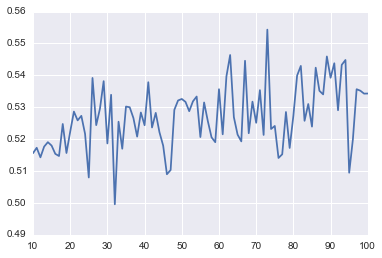

In [80]:
plt.plot(range(10, 101), auc)

In [ ]:
# Grid param modified to only store the ones preferred
random_forest_grid = {
                      'max_depth': [3, 6, 9],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [5, 10, 15],
                      'min_samples_leaf': [5, 10, 15],
                      'bootstrap': [False, True],
                      'n_estimators': [100],
                      'random_state': [None, 20, 200],
                      'class_weight': ['auto', 'subsample', None]
                     }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X, y)

print "best parameters:", rf_gridsearch.best_params_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


In [105]:
rnf = RandomForestClassifier(class_weight='auto', n_estimators=100)
rnf.fit(X_train, y_train)
rnf_df = pd.DataFrame(X_test, columns=df2.columns)
rnf_df['proba'] = pd.Series([x[1] for x in rnf.predict_proba(X_test)])
rnf_df['label'] = pd.Series(y_test)

In [125]:
rnf_df['proba_bins'] = pd.cut(rnf_df['proba'], bins=3)

In [126]:
rnf_df.head().T

,0,1,2,3,4
zone_beat_id,18,17,18,18,19
condition_id,39.2,37,46.9,51.8,33.1
winddir_id,3,3,5,4,5
hour,0,0,0,21.9,0
dow,0,0,0,0,0
month,7,19,22,14,18
mariner_plays,87,71,69,68,70
seahawk_plays,0,0,0,0,0
dewpoint,12,11,11,7,11
gustspeed,0,0,0,0,0


In [127]:
rnf_df[['proba_bins', 'label']].groupby('proba_bins', as_index=False).agg({'label': ['sum','mean', 'count']})

proba_bins label                
                      sum      mean count
0  (-0.00057, 0.19]    79  0.039939  1978
1      (0.19, 0.38]     1  0.062500    16
2      (0.38, 0.57]     2  0.333333     6